In [102]:
import pandas as pd
import numpy as np

def airlineForecast(trainingDataFileName, validationDataFileName):
    # Step 1: Load the training and validation datasets
    training = pd.read_csv(trainingDataFileName)
    validation = pd.read_csv(validationDataFileName)
    
    print("Training Data:")
    print(training.head())
    print("\nValidation Data:")
    print(validation.head())
    
    # Convert date columns to datetime
    training['booking_date'] = pd.to_datetime(training['booking_date'])
    training['departure_date'] = pd.to_datetime(training['departure_date'])
    validation['booking_date'] = pd.to_datetime(validation['booking_date'])
    validation['departure_date'] = pd.to_datetime(validation['departure_date'])
    
    print("\nTraining Data Types:")
    print(training.dtypes)
    print("\nValidation Data Types:")
    print(validation.dtypes)
    
    # Add day of the week for both booking and departure dates
    training['booking_day_of_week'] = training['booking_date'].dt.day_name()
    training['departure_day_of_week'] = training['departure_date'].dt.day_name()
    validation['booking_day_of_week'] = validation['booking_date'].dt.day_name()
    validation['departure_day_of_week'] = validation['departure_date'].dt.day_name()
    
    print("\nTraining Data with Day of Week:")
    print(training.head())
    print("\nValidation Data with Day of Week:")
    print(validation.head())
    
    # Step 2: Calculate days_prior for both training and validation data
    training['days_prior'] = (training['departure_date'] - training['booking_date']).dt.days
    validation['days_prior'] = (validation['departure_date'] - validation['booking_date']).dt.days
    
    print("\nTraining Data with Days Prior:")
    print(training.head())
    print("\nValidation Data with Days Prior:")
    print(validation.head())
    
    # Step 3: Calculate final demand for both training and validation data
    # Final demand calculation for training data
    days_prior_train = training.loc[training.days_prior == 0, ['departure_date', 'cum_bookings']]
    days_prior_train['final_demand'] = days_prior_train['cum_bookings']
    days_prior_train = days_prior_train[['departure_date', 'final_demand']]
    training = training.merge(days_prior_train, on='departure_date', how='left')

    # Final demand calculation for validation data 
    days_prior_val = validation.loc[validation.days_prior == 0, ['departure_date', 'cum_bookings']]
    days_prior_val['final_demand'] = days_prior_val['cum_bookings']
    days_prior_val = days_prior_val[['departure_date', 'final_demand']]
    validation = validation.merge(days_prior_val, on='departure_date', how='left')

    # Ensure no NaN in final_demand for validation data
    validation['final_demand'] = validation['final_demand'].fillna(0)
    
    print("\nTraining Data with Final Demand:")
    print(training.head())
    print("\nValidation Data with Final Demand:")
    print(validation.head())
    
    # Step 4: Calculate remaining demand and booking rate for training data
    training['remaining_demand'] = training['final_demand'] - training['cum_bookings']
    training['booking_rate'] = training['cum_bookings'] / training['final_demand']
    
    print("\nTraining Data with Remaining Demand and Booking Rate:")
    print(training.head())
    
    # Step 5: Calculate averages by days_prior and day of week
    avg_cum_bookings = training.groupby(['days_prior', 'departure_day_of_week'])['cum_bookings'].mean().reset_index().rename(columns={'cum_bookings': 'avg_cum_bookings'})
    avg_fin_demand = training.groupby(['days_prior', 'departure_day_of_week'])['final_demand'].mean().reset_index().rename(columns={'final_demand': 'avg_fin_demand'})
    avg_rem_demand = training.groupby(['days_prior', 'departure_day_of_week'])['remaining_demand'].mean().reset_index().rename(columns={'remaining_demand': 'avg_rem_demand'})
    booking_rate_avg = training.groupby(['days_prior', 'departure_day_of_week'])['booking_rate'].mean().reset_index().rename(columns={'booking_rate': 'booking_rate_avg'})

    # Combine averages into a single DataFrame
    avg_cum_bookings = avg_cum_bookings.merge(avg_fin_demand, on=['days_prior', 'departure_day_of_week'])
    avg_cum_bookings = avg_cum_bookings.merge(avg_rem_demand, on=['days_prior', 'departure_day_of_week'])
    avg_cum_bookings = avg_cum_bookings.merge(booking_rate_avg, on=['days_prior', 'departure_day_of_week'])

    # Calculate average booking rate
    avg_cum_bookings['avg_booking_rate'] = avg_cum_bookings['avg_cum_bookings'] / avg_cum_bookings['avg_fin_demand']
    
    print("\nAverages by Days Prior and Day of Week:")
    print(avg_cum_bookings.head())
    
    # Step 6: Merge averages into the validation data
    validation = validation.merge(avg_cum_bookings, on=['days_prior', 'departure_day_of_week'], how='left')
    
    print("\nValidation Data with Merged Averages:")
    print(validation.head())

    # Step 7: Additive and Multiplicative Forecasts
    validation['additive_fcst'] = validation['cum_bookings'] + validation['avg_rem_demand']
    validation['multiplicative_fcst'] = validation['cum_bookings'] / validation['avg_booking_rate']
    
    print("\nValidation Data with Forecasts:")
    print(validation[['departure_date', 'booking_date', 'additive_fcst', 'multiplicative_fcst']].head())

    # Step 9: Calculate MASE for Additive and Multiplicative Models
    sum_add_mase = abs(validation['final_demand'] - validation['additive_fcst']).sum() / abs(validation['final_demand'] - validation['naive_fcst']).sum()
    sum_mult_mase = abs(validation['final_demand'] - validation['multiplicative_fcst']).sum() / abs(validation['final_demand'] - validation['naive_fcst']).sum()
    
    print("\nMASE (Additive Model):", sum_add_mase)
    print("MASE (Multiplicative Model):", sum_mult_mase)

    # Step 10: Return the results without printing inside the function
    forecasts = validation[['departure_date', 'booking_date', 'additive_fcst', 'multiplicative_fcst', 'booking_day_of_week', 'departure_day_of_week']]
    return { 'MASE_Additive': sum_add_mase, 'MASE_Multiplicative': sum_mult_mase, 'forecasts': forecasts }

results = airlineForecast("airline_data_training.csv", "airline_data_validation.csv")

# Now print the MASE results and forecast DataFrame
print("Forecasts:")
print(results['forecasts'])

Training Data:
  departure_date booking_date  cum_bookings
0      8/16/2012    6/17/2012             0
1      8/16/2012    6/18/2012             0
2      8/16/2012    6/19/2012             0
3      8/16/2012    6/20/2012             2
4      8/16/2012    6/21/2012             2

Validation Data:
  departure_date booking_date  cum_bookings  naive_fcst
0      11/1/2012    11/1/2012           269         NaN
1      11/1/2012   10/31/2012           232  265.250000
2      11/1/2012   10/30/2012           214  264.250000
3      11/1/2012   10/29/2012           203  265.083333
4      11/1/2012   10/28/2012           185  258.416667

Training Data Types:
departure_date    datetime64[ns]
booking_date      datetime64[ns]
cum_bookings               int64
dtype: object

Validation Data Types:
departure_date    datetime64[ns]
booking_date      datetime64[ns]
cum_bookings               int64
naive_fcst               float64
dtype: object

Training Data with Day of Week:
  departure_date booking_date

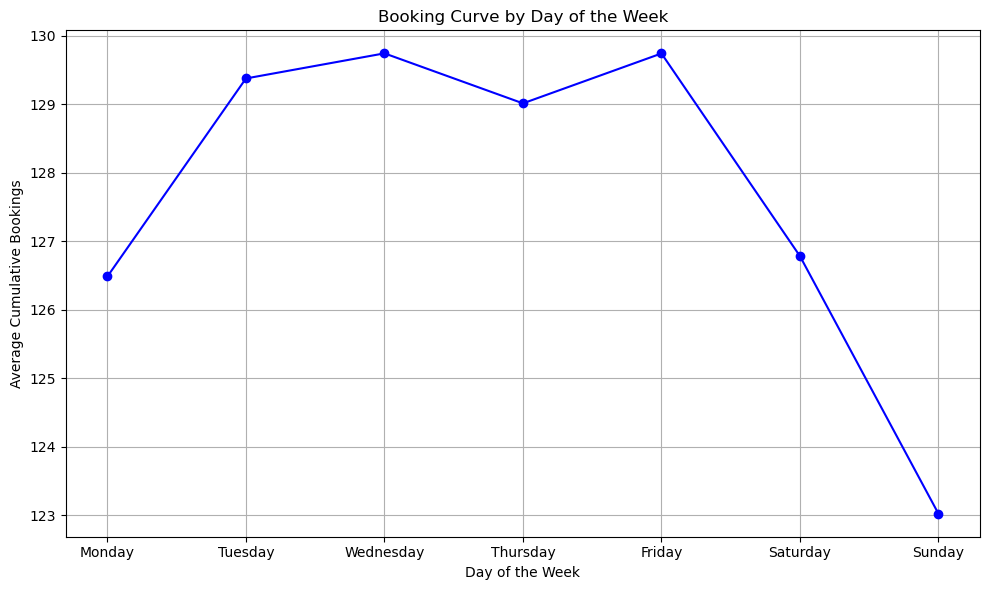

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

def airlineForecast(trainingDataFileName, validationDataFileName):
    # Step 1: Load the training and validation datasets
    training = pd.read_csv(trainingDataFileName)
    validation = pd.read_csv(validationDataFileName)
    
    # Convert date columns to datetime
    training['booking_date'] = pd.to_datetime(training['booking_date'])
    training['departure_date'] = pd.to_datetime(training['departure_date'])
    validation['booking_date'] = pd.to_datetime(validation['booking_date'])
    validation['departure_date'] = pd.to_datetime(validation['departure_date'])

    # Step 2: Extract the day of the week from booking date
    training['booking_day_of_week'] = training['booking_date'].dt.day_name()

    # Step 3: Calculate the average cumulative bookings for each day of the week
    avg_booking_by_day = training.groupby('booking_day_of_week')['cum_bookings'].mean().reset_index()

    # Step 4: Reorder days of the week to ensure proper ordering
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    avg_booking_by_day['booking_day_of_week'] = pd.Categorical(avg_booking_by_day['booking_day_of_week'], categories=day_order, ordered=True)
    avg_booking_by_day = avg_booking_by_day.sort_values('booking_day_of_week')

    # Step 5: Plot the booking curve by day of the week
    plt.figure(figsize=(10,6))
    plt.plot(avg_booking_by_day['booking_day_of_week'], avg_booking_by_day['cum_bookings'], marker='o', color='b', linestyle='-', label='Booking Curve')
    plt.xlabel('Day of the Week')
    plt.ylabel('Average Cumulative Bookings')
    plt.title('Booking Curve by Day of the Week')
    plt.grid(True)
    plt.tight_layout()

    # Step 6: Save and display the plot
    plt.savefig('booking_curve_by_day_of_week.png')
    plt.show()

    # Return the booking curve for further analysis if needed
    return avg_booking_by_day

# Example usage:
results = airlineForecast("airline_data_training.csv", "airline_data_validation.csv")
